# SVM Kernels: What Do They Actually Do?
## An intuitive visual explanation

You may have heard about the so-called kernel trick, a maneuver that allows support vector machines, or SVMs, to work well with non-linear data. The idea is to map the data into a high-dimensional space in which it becomes linear and then apply a simple, linear SVM. Sounds sophisticated and to some extent it is. However, while it might be hard to understand how the kernels work, it is pretty easy to grasp what they are trying to achieve. Read on to see it for yourself!

In [2]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import LinearSVC, SVC

import matplotlib.pyplot as plt
%matplotlib inline

from mlxtend.plotting import plot_decision_regions
import numpy as np

In [3]:
def plot_svm(clf, X):
    decision_function = pipe.decision_function(X)
    support_vector_indices = np.where((2 * y - 1) * decision_function <= 1)[0]
    support_vectors = X[support_vector_indices]
    
    plt.figure(figsize=(8, 8))
    plot_decision_regions(X, y, clf=pipe, legend=0, 
                          colors="skyblue,xkcd:goldenrod")
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=200,
                linewidth=1, facecolors='none', edgecolors='r')
    
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = pipe.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])

### When data are linearly separable: a linear SVM

First things first: how does the vanilla SVM work? We can use SVMs for both classification and regression tasks, but in this article, we'll focus on the former. Let's first consider data with two classes that are linearly separable. We will create two separate blobs of points and fit a linear SVM to them using scikit-learn. Note that we normalize the data before fitting the model since SVMs are sensitive to features' scales. 

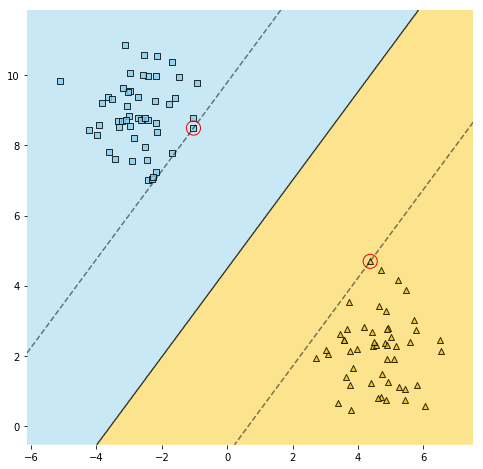

In [8]:
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=42)
pipe = make_pipeline(StandardScaler(), LinearSVC(C=1, loss="hinge"))
pipe.fit(X, y)

plot_svm(pipe, X)

There are many lines that separate the two classes perfectly, infinitely many, to be exact. The line fitted by the SVM is special in that it is the middle line of a band marked with the dashed lines, and this band is the widest possible band that can be squeezed between the two classes. This way, the SVM decision line (marked as a solid black line) is as far from both classes as possible, ensuring the model will generalize well to new examples. 

The observations on the border of the band circled in red are called support vectors since they support, or determine, the location of the band. Should we add some observations outside the band, it would not change position.

As a side note: this is an example of hard-margin classification, which means no observations are allowed into the band. Alternatively, we could do a soft-margin classification: allow some observation into the band, but not too many, making the band even wider at the same time. That would be more robust against outliers and can be controlled by the parameter C in LinearSVC(): we have set it to 1, but decreasing it to 0.1, for instance, would result in a wider band, but with some observations inside it. Anyway, this is not that relevant to our story.

Most real-life data sets are not nice, linearly separable blobs. Let's see how the linear SVM handles moon-shaped data.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


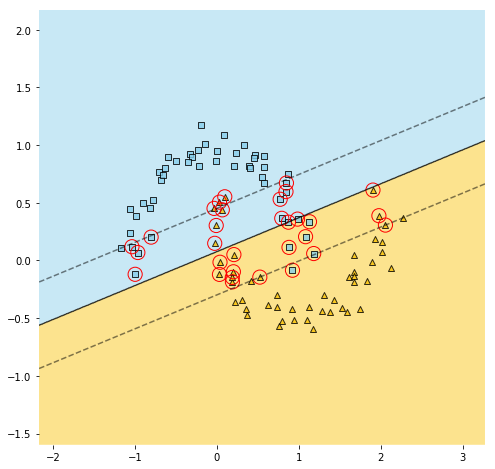

In [129]:
X, y = make_moons(n_samples=100, noise=0.1, random_state=42)
pipe = make_pipeline(StandardScaler(), LinearSVC(C=1, loss="hinge"))
pipe.fit(X, y)

plot_svm(pipe, X)

This doesn't look good, does it? Let's see what we can do about it.

### Mapping to higher dimensions

Before we discuss the kernels and what they do, let's first look at one powerful idea they make use of: in a high dimensional space, there is a bigger chance the data will become linearly separable. 
This is clearly illustrated by the following pair of plots. When we only have one feature, x1, we cannot separate the data with a single line. Adding another feature, x2, equal to x1 squared, makes it easy to separate the two classes.

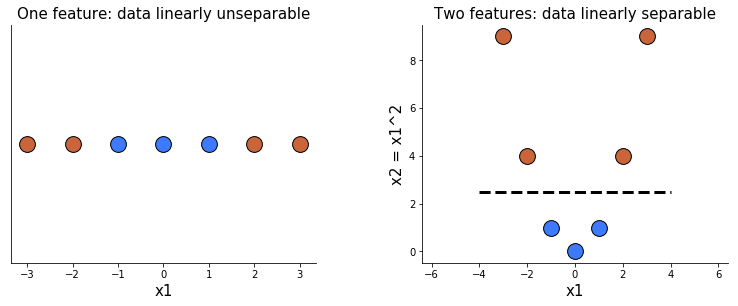

In [198]:
x1 = np.array([-3, -2, -1, 0, 1, 2, 3])
x2 = x1 ** 2
aux = np.zeros(shape=x1.shape)
y = np.array([0, 0, 1, 1, 1 ,0, 0])

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x1[y == 1], aux[y == 1], c=['xkcd:lightish blue'], 
            edgecolor="black", s=250)
plt.scatter(x1[y == 0], aux[y == 0], c=['xkcd:terra cotta'], 
            edgecolor="black", s=250)
plt.axis("equal")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks([])
plt.xlabel("x1", fontsize=15)
plt.title("One feature: data linearly unseparable", fontsize=15)
plt.subplot(1, 2, 2)
plt.scatter(x1[y == 1], x2[y == 1], c=['xkcd:lightish blue'], 
            edgecolor="black", s=250)
plt.scatter(x1[y == 0], x2[y == 0], c=['xkcd:terra cotta'], 
            edgecolor="black", s=250)
plt.axis("equal")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel("x1", fontsize=15)
plt.ylabel("x2 = x1^2", fontsize=15)
plt.plot([-4, 4], [2.5, 2.5], linestyle='--', lw=3, color='black')
plt.title("Two features: data linearly separable", fontsize=15)
plt.tight_layout(7)
plt.show()

### What is a kernel anyway?

So, what is the kernel trick about? Kernels are simply a smart way of adding more features to the data in the hope of making it linearly separable. Smart, because instead of actually adding them, which would make the model slow, they make use of some magical mathematical properties (which are out of scope of this article) that allow us to obtain exactly the same results as if we had actually added these features, without slowing the model down. 

Two popular kernels are the polynomial kernel and the Gaussian Radial Basis Function, or RBF, kernel. They differ in the types of features that they (pretend to) add. Let's look at what they do!

### Polynomial features with polynomial kernel

One way to create more features is to use their polynomial combinations up to a certain degree. For instance, with two features A and B, a polynomial of degree 2 would produce 6 features: 1 (any feature to power 0), A, B, A², B², and AB. We can easily add these features manually with scikit-learn's PolynomialFeatures():

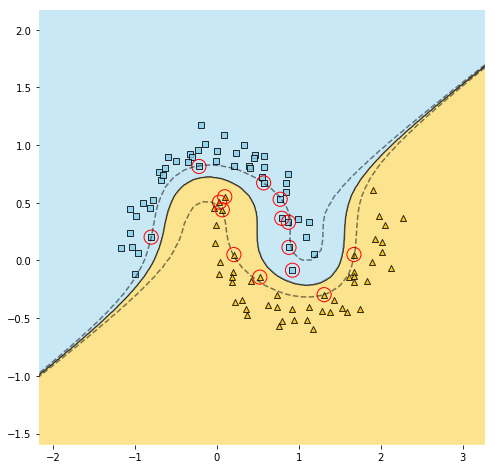

In [10]:
X, y = make_moons(n_samples=100, noise=0.1, random_state=42)
pipe = make_pipeline(StandardScaler(), 
                     PolynomialFeatures(degree=3), 
                     LinearSVC(C=5))
pipe.fit(X, y)
plot_svm(pipe, X)

or we can simply use a polynomial kernel:

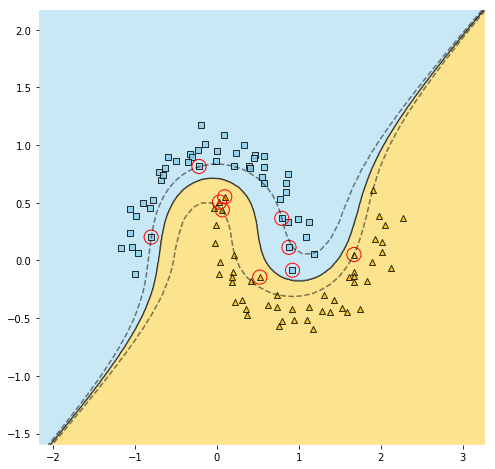

In [9]:
X, y = make_moons(n_samples=100, noise=0.1, random_state=42)
pipe = make_pipeline(StandardScaler(), SVC(kernel="poly", degree=3, C=5, coef0=1))
pipe.fit(X, y)

plot_svm(pipe, X)
plt.show()

The advantage of using the kernelized version is that you can specify the degree to be large, thus increasing the chance that data will become linearly separable in this high-dimensional space, without slowing the model down. 

For our moon-data example, it is clear from the scatter plot that a polynomial of degree 3 would be enough. For more complex datasets, however, you might need to use a higher degree. This is when the power of the kernel trick is unleashed.

### Similarity features with Gaussian RBF kernel

Another method to add more features to the data is to use the so-called similarity features. A similarity feature measures how far a value of an existing feature is from a landmark. Let's make it practical: we have a data set with a single feature, x1. We want to create two similarity features, so we select two landmarks, i.e. reference values from our single feature. Let's take -1 and 1, for instance. Then, for each value of x1, we calculate how far it is from the first landmark (read on to see how to define 'far'). This is our new similarity feature, x2. Then we do the same, comparing values of x1 to the second landmark to obtain x3. Now we don't even need the original feature x1! The two new similarity features make our data easily separable.

In [5]:
def gaussian_rbf (x, landmark, gamma):
    return np.exp(-gamma * (x - landmark) ** 2)

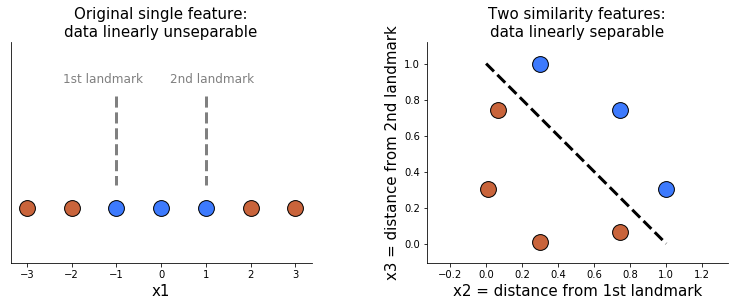

In [25]:
x1 = np.array([-3, -2, -1, 0, 1, 2, 3])
landmarks = [-1, 1]
x2 = np.array([gaussian_rbf(x, landmarks[0], 0.3) for x in x1])
x3 = np.array([gaussian_rbf(x, landmarks[1], 0.3) for x in x1])
aux = np.zeros(shape=x1.shape)
y = np.array([0, 0, 1, 1, 1 ,0, 0])

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x1[y == 1], aux[y == 1], c=['xkcd:lightish blue'], 
            edgecolor="black", s=250)
plt.scatter(x1[y == 0], aux[y == 0], c=['xkcd:terra cotta'], 
            edgecolor="black", s=250)
plt.plot([landmarks[0], landmarks[0]], [2.5, 0.5], linestyle='--', lw=3, color='gray')
plt.plot([landmarks[1], landmarks[1]], [2.5, 0.5], linestyle='--', lw=3, color='gray')
plt.annotate("1st landmark", (landmarks[0] - 1.2, 2.8), fontsize=12, color='gray')
plt.annotate("2nd landmark", (landmarks[1] - 0.8, 2.8), fontsize=12, color='gray')
plt.axis("equal")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks([])
plt.xlabel("x1", fontsize=15)
plt.title("Original single feature:\ndata linearly unseparable", fontsize=15)
plt.subplot(1, 2, 2)

plt.scatter(x2[y == 1], x3[y == 1], c=['xkcd:lightish blue'], 
            edgecolor="black", s=250)
plt.scatter(x2[y == 0], x3[y == 0], c=['xkcd:terra cotta'], 
            edgecolor="black", s=250)
plt.axis("equal")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel("x2 = distance from 1st landmark", fontsize=15)
plt.ylabel("x3 = distance from 2nd landmark", fontsize=15)
plt.plot([0, 1], [1, 0], linestyle='--', lw=3, color='black')
plt.title("Two similarity features:\ndata linearly separable", fontsize=15)
plt.tight_layout(7)
plt.show()

So, how do we calculate the distance of each observation from the landmark? A popular choice is to use the Gaussian Radial Basis Function, or RBF. It is defined as:

$RBF(x) = exp(- \gamma * ||x - landmark||^{2})$

where x is our original feature and γ is a parameter, which I set to be 0.3. 

For example, the first observation scores -3 on our only original feature. We computed x2 as exp(-0.3 * (-3-(-1))²)≈0.30, and x3 as exp(-0.3 * (-3-(1))²)≈0.01. That's the bottom-most dot on the right-hand-side plot.

In the above example, we have luckily chosen two landmarks that happened to work well. In practice, one might need a lot of landmarks, which translates to many new similarity features. That would slow the SVM down a lot - unless we resort to the kernel trick! Analogous to the polynomial kernel, the RBF kernel allows us to obtain exactly the same results as though we had added a landmark at each value of the original feature without the need to actually do it. Let's try it out at our moon-shaped data.

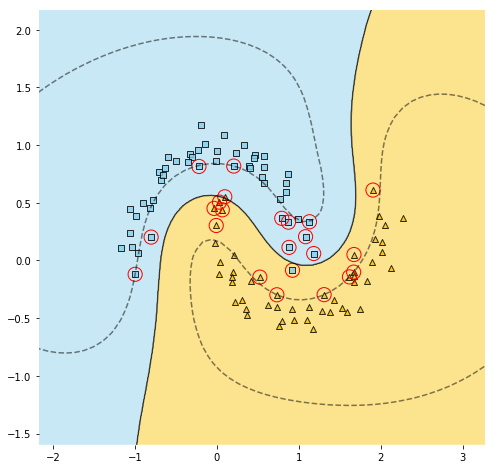

In [44]:
X, y = make_moons(n_samples=100, noise=0.1, random_state=42)
pipe = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma=0.3, C=5))
pipe.fit(X, y)

plot_svm(pipe, X)
plt.show()

The decision boundary looks pretty decent, but you might have noticed some misclassified examples. We can fix it by tuning the γ parameter. It acts as a regularizer - the smaller it is, the smoother the decision boundary, which prevents overfitting. In this case, however, we seem to actually be underfitting, so let's increase γ to 0.5.

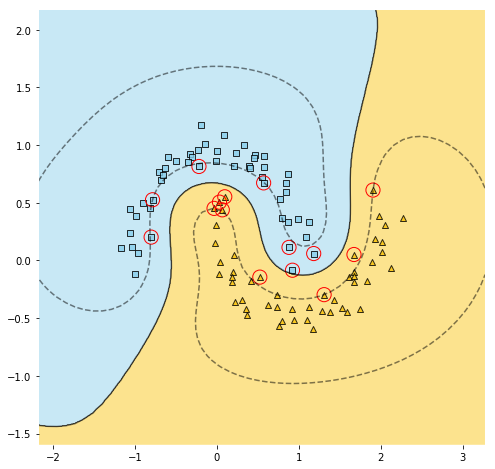

In [49]:
X, y = make_moons(n_samples=100, noise=0.1, random_state=42)
pipe = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma=0.5, C=5))
pipe.fit(X, y)

plot_svm(pipe, X)
plt.show()

Now all examples have been classifier correctly!

### Summary

* Support Vector Machines perform classification by finding linear decision boundaries that are as far away from the data as possible. They work great with linearly separable data but fail miserably otherwise.
* To make non-linear data linearly separable (and thus convenient for SVMs) we can add more features to the data since in a higher-dimensional space the probability of the data being linearly separable increases.
* Two popular types of new features to add are polynomial combinations of existing features (polynomial features) and observation-wise distances from landmarks, i.e. some reference values (similarity features).
* Actually adding them might slow the model down to the extent of making it useless.
* The kernel trick is a smart maneuver that takes advantage of some mathematical properties in order to deliver the same results as though we have added additional features without actually adding them.
* The polynomial and RBF kernels (pretend to) add the polynomial and similarity features, respectively.